In [177]:
from __future__ import absolute_import, division, print_function

import pathlib

from astropy.io import fits

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Activation, Conv1D
print(tf.__version__)

1.14.0


In [345]:
import matplotlib as m
fig_size = (8,6)
font = 'Helvetica'
params = {'backend': 'tkagg',
          'axes.labelsize': 9,
          'axes.titlesize': 9,
          'font.size': 8,
          'legend.fontsize': 9,
          'font.family': 'sans-serif',
          'font.sans-serif': font,
          'xtick.labelsize': 8,
          'ytick.labelsize': 8,
          'text.usetex': True,
          'figure.figsize': fig_size,
          'figure.dpi': 80,
          'lines.linewidth': 1.0,
          'axes.linewidth':1.0,
          'image.interpolation'  : 'nearest',
          'xtick.major.size'     : 5,      # major tick size in points
          'xtick.minor.size'     : 3.5,      # minor tick size in points
          'xtick.major.width'    : 0.5,    # major tick width in points
          'xtick.minor.width'    : 0.3,    # minor tick width in points
          'axes.spines.top': False,
          'axes.spines.right':False,
          'xtick.top': False,
          'ytick.right': False,
          'axes.formatter.useoffset': False
}
m.rcParams.update(params)
m.rcParams['text.latex.preamble'] = [
       r'\usepackage{siunitx}',   # i need upright \micro symbols, but you need...
       r'\sisetup{detect-all}',   # ...this to force siunitx to actually use your fonts
       r'\usepackage{helvet}',    # set the normal font here
       r'\usepackage{sansmath}',  # load up the sansmath so that math -> helvet
       r'\sansmath'               # <- tricky! -- gotta actually tell tex to use!
]

m.rcParams['mathtext.fontset'] = 'custom'
m.rcParams['mathtext.rm'] = font
m.rcParams['mathtext.it'] = font+':italic'
m.rcParams['mathtext.bf'] = font+':bold'
m.rcParams['text.latex.preamble'] = [r"\usepackage{amsmath}"]


In [561]:
def build_conv_model1():
  #build the NN needed for the problem accomodating a single
  #convolutional layer and two densely connected hidden layer
  kSzConv1D = 5
  model = keras.Sequential([
    layers.Conv1D(25, (3,),
        activation='relu',strides=1,input_shape=[waveNumd,1]),
    layers.Conv1D(15, (3,),
        activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(15, (3,),
        activation='relu'),
    layers.Conv1D(25, (3,),
        activation='relu'),
    layers.MaxPooling1D(2),
    #layers.GlobalAveragePooling1D(),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(30,activation=tf.nn.relu),
    layers.Dense(30,activation=tf.nn.relu),  
    #layers.GlobalAveragePooling1D(),
    #layers.Dense(20, activation='sigmoid'),    
    #layers.Dense(10, activation='sigmoid'),
    layers.Dense(waveNumd-1)])
  optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9,
          beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
  #optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.1,
  #                                          initial_accumulator_value=0.1, epsilon=1e-07)


  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

def build_conv_model():
    #build the NN needed for the problem accomodating a single
    #convolutional layer and two densely connected hidden layer
    kSzConv1D = 5
    y1 = layers.Input(shape=[waveNumd,1])
    y = layers.Conv1D(20, (3,), activation='relu')(y1)
    y = layers.MaxPooling1D(2)(y)
    y = layers.Conv1D(40, (3,), activation='relu')(y)
    y = layers.MaxPooling1D(2)(y)
    y = layers.Conv1D(60, (3,), activation='relu')(y)
    y = layers.MaxPooling1D(2)(y)
    y = layers.Dense(60,activation='relu')(y)
    y = layers.UpSampling1D()(y)
    y = layers.Conv1D(40,(3,), activation='relu')(y)
    y = layers.Dropout(0.2)(y)
    y = layers.UpSampling1D()(y)
    y = layers.Conv1D(20,(5,), activation='relu')(y)

    #layers.GlobalAveragePooling1D(),
    #y = layers.Flatten()(y)
    #y = layers.Dropout(0.5)(y)
    y = layers.Flatten()(y)
    y = layers.Dense(waveNumd-1,activation=tf.nn.relu)(y)
    y2 = layers.Add()([y,y1[:,:-1,0]])
    #y = layers.Dense(40,activation=tf.nn.relu)(y2)

      #layers.GlobalAveragePooling1D(),
      #layers.Dense(20, activation='sigmoid'),    
      #layers.Dense(10, activation='sigmoid'),
    x = layers.Dense(waveNumd-1,activation='linear')(y2)
    optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9,
            beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model = keras.models.Model(inputs=y1, outputs=x)
    model.compile(loss='mean_squared_error',
                  optimizer=optimizer,
                  metrics=['mean_absolute_error', 'mean_squared_error'])

    return model

def build_dense_model():
    y1 = layers.Input(shape=[waveNumd,1])
    y = layers.Flatten()(y1)
    y = layers.Dense(128,activation='relu')(y)
    #y = layers.Dense(256,activation='relu')(y)
    y = layers.Dense(128,activation='relu')(y)
    y = layers.Dropout(0.4)(y)
    y = layers.Dense(128,activation='relu')(y)
    y = layers.Dense(128,activation='relu')(y)
   # y = layers.Dense(256,activation='relu')(y)
    #y = layers.Flatten()(y)
    y = layers.Dense(waveNumd-1)(y)
    y = layers.Add()([y,y1[:,:-1,0]])
    x = layers.Dense(waveNumd-1,activation='linear')(y)
    
    optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9,
            beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model = keras.models.Model(inputs=y1, outputs=x)
    model.compile(loss='mean_squared_error',
                  optimizer=optimizer,
                  metrics=['mean_absolute_error', 'mean_squared_error'])
    
    return model 

def load_spectral_profiles(directory,filename):
    hdul     = fits.open(directory+filename)
    spectrum = hdul[0].data
    return spectrum 

def radial_dist(sizeX,sizeY):
    '''Prepare a flat array of the radial distance of the pixel
    from the optical center of the system -- used for removing 
    uncorrected blueshifts
    '''
    
    centerX = sizeX/2
    centerY = sizeY/2
    
    radialDistances = np.zeros((sizeX,sizeY))
    
    for ii in range(sizeX):
        for jj in range(sizeY):
            radialDistances[ii,jj] = (centerX-ii)**2 + (centerY-jj)**2
    
    radialDistances = np.reshape(radialDistances,(sizeX*sizeY))
    
    return radialDistances


def prepare_data(spectrum):
    shape = spectrum.shape
    spec = np.reshape(spectrum,(shape[0],shape[1]*shape[2]))
    spec = np.swapaxes(spec,0,1)
    return spec
    
def plot_spec_profile_comparison(wavescale,profile_FP1,profile_FP2,profile_inferred):
    plt.figure(dpi=250)
    plt.style.use('ggplot')
    plt.plot(wavescale,profile_FP1,'g.--',label='FP1')
    plt.plot(wavescale,profile_FP2,'b.--',label='FP2')
    plt.plot(wavescale,profile_inferred,'k.--',label = 'Inferred')
    plt.legend()
    plt.ylabel('Normalized Intensity')
    plt.xlabel('Wavelength, $\AA$')
    plt.show()
    
def Lorentzian(x0,x,gamma):
    x2  = (x0-x)*(x0-x)
    exp = gamma/(np.pi*(x2+gamma*gamma))
    return exp

def Gaussian(x,mu,sigma):
    
    return np.exp((-1)*(x-mu)*(x-mu)/(2*sigma*sigma))/np.sqrt(2*np.pi*sigma*sigma)
    
def produce_FP_transmission_peak(Type,dlambda,Dlambda,):
    
    return filterProfile

def convolve(signal,filterProfile):
    return np.convolve(signal,filterProfile)

In [568]:
model = build_conv_model()
model.summary()

Model: "model_66"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_102 (InputLayer)          [(None, 41, 1)]      0                                            
__________________________________________________________________________________________________
conv1d_382 (Conv1D)             (None, 39, 20)       80          input_102[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_203 (MaxPooling1D (None, 19, 20)       0           conv1d_382[0][0]                 
__________________________________________________________________________________________________
conv1d_383 (Conv1D)             (None, 17, 40)       2440        max_pooling1d_203[0][0]          
___________________________________________________________________________________________

In [547]:
sizeX = 968
sizeY = 968

waveCut0 = 25
waveCut1 = 65
waveNumd = waveCut1-waveCut0+1

waveNum  = 76

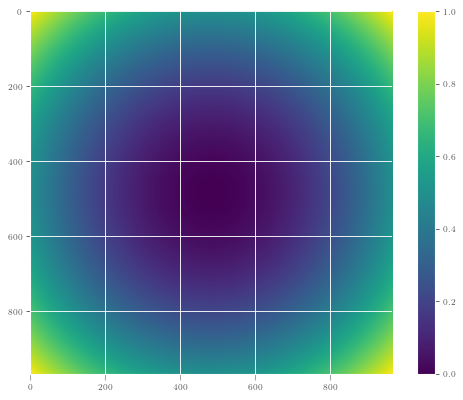

(89, 968, 968)


In [550]:
indices = radial_dist(sizeX,sizeY)

indices = indices / max(indices.flatten())
        
im1 = plt.imshow(np.reshape(indices,(sizeX,sizeY)))
plt.colorbar(im1)
plt.show() 

spec1 = (load_spectral_profiles('','even_ca_1fp.fits'))
waveNum  = (spec1.shape)[0]
spec1 = np.reshape(spec1,(waveNum,sizeX*sizeY))
spec1 = np.swapaxes(spec1,0,1)

spec2 = (load_spectral_profiles('','even_ca_2fp.fits'))
print(spec2.shape)
spec2 = np.reshape(spec2,(waveNum,sizeX*sizeY))
spec2 = np.swapaxes(spec2,0,1)

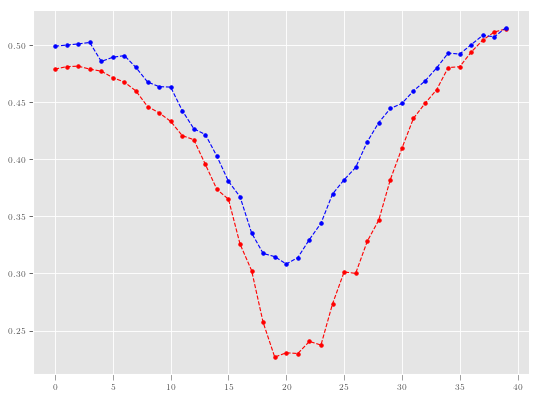

(937024, 40)
Average continuum in training set is 1.000000
Average continuum in truth set is 1.000000


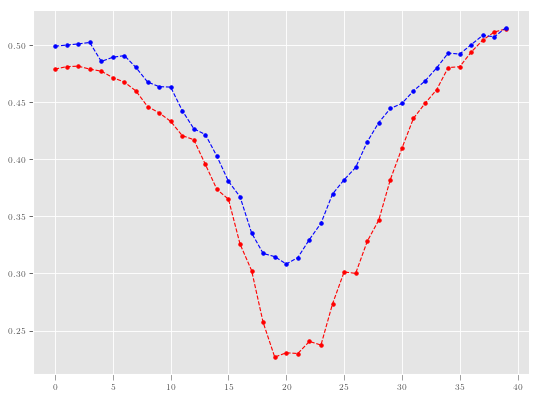

2FP set dimensions are:937024,1,41
2FP set dimensions are:937024,40


In [565]:
norm    = 1
offset  = 0

train_set1 = spec1[:,waveCut0:waveCut1]
truth_set1 = spec2[:,waveCut0:waveCut1]
plt.plot(truth_set1[200000,:],'r.--')
plt.plot(train_set1[200000,:],'b.--')
plt.show()

print(train_set1.shape)
cont_train = np.mean((train_set1[:,3]+train_set1[:,-3]))
cont_truth = np.mean((truth_set1[:,3]+truth_set1[:,-3]))
print('Average continuum in training set is %f'%cont_train)
print('Average continuum in truth set is %f'%cont_truth)

'''
for ii in range(train_set1.shape[0]):
    cont_12     =  0.5*(train_set1[ii,2]+train_set1[ii,-2])
    if np.isnan(cont_12) == True:
        print(np.isnan(cont_12))
    #print(cont_12)
    train_set1[ii,:] = train_set1[ii,:] / cont_12

for ii in range(truth_set1.shape[0]):
    cont_12     =  0.5*(truth_set1[ii,2]+truth_set1[ii,-2])
    if np.isnan(cont_12) == True:
                print(np.isnan(cont_12))
    truth_set1[ii,:] = truth_set1[ii,:] / cont_12
'''

for ii in range(train_set1.shape[0]):
    train_set1[ii,:] = train_set1[ii,:]/cont_train
    truth_set1[ii,:] = truth_set1[ii,:]/cont_train
    
plt.plot(truth_set1[200000,:],'r.--')
plt.plot(train_set1[200000,:],'b.--')
plt.show()


train_set = np.zeros((sizeX*sizeY,1,(waveNumd)))
truth_set = np.zeros((sizeX*sizeY,(waveNumd-1)))
print('2FP set dimensions are:%d,%d,%d'%train_set.shape)
train_set[:,0,0:(waveNumd-1)] = train_set1
train_set[:,0,(waveNumd-1)]   = indices
truth_set        = truth_set1

train_set = (np.swapaxes(train_set,1,2))
print('2FP set dimensions are:%d,%d'%truth_set.shape)
#truth_set = (np.swapaxes(truth_set,0,1))
#print(truth_set.shape)


plt.plot(truth_set[200000,:],'r.--')
plt.plot(train_set[200000,:],'b.--')
plt.show()

In [573]:
EPOCHS = 4
#print(train_set)

optimizer = 'Adam'
#optimizer = 'SGD'

if optimizer == 'Adam':
    model.optimizer = tf.keras.optimizers.Adam(lr=1e-3, beta_1=0.9,
              beta_2=0.999, epsilon=None, decay=1.0, amsgrad=False)

if optimizer == 'SGD': 
    model.optimizer = tf.keras.optimizers.SGD(lr=1e-7, nesterov=True)

    
history = model.fit((train_set)[90000:-90000,:,:],truth_set[90000:-90000,:],
                    epochs=EPOCHS,validation_split=0.15 , verbose=1)

Train on 643470 samples, validate on 113554 samples
Epoch 1/4
643470/643470 [==============================] - 131s 204us/sample - loss: 0.0010 - mean_absolute_error: 0.0247 - mean_squared_error: 0.0010 - val_loss: 9.8502e-04 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 9.8502e-04
Epoch 2/4
643470/643470 [==============================] - 133s 207us/sample - loss: 0.0010 - mean_absolute_error: 0.0246 - mean_squared_error: 0.0010 - val_loss: 9.8333e-04 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 9.8333e-04
Epoch 3/4
643470/643470 [==============================] - 130s 202us/sample - loss: 0.0010 - mean_absolute_error: 0.0245 - mean_squared_error: 0.0010 - val_loss: 9.8222e-04 - val_mean_absolute_error: 0.0239 - val_mean_squared_error: 9.8222e-04
Epoch 4/4
643470/643470 [==============================] - 120s 187us/sample - loss: 0.0010 - mean_absolute_error: 0.0244 - mean_squared_error: 0.0010 - val_loss: 9.8021e-04 - val_mean_absolute_error: 0.0239 - val

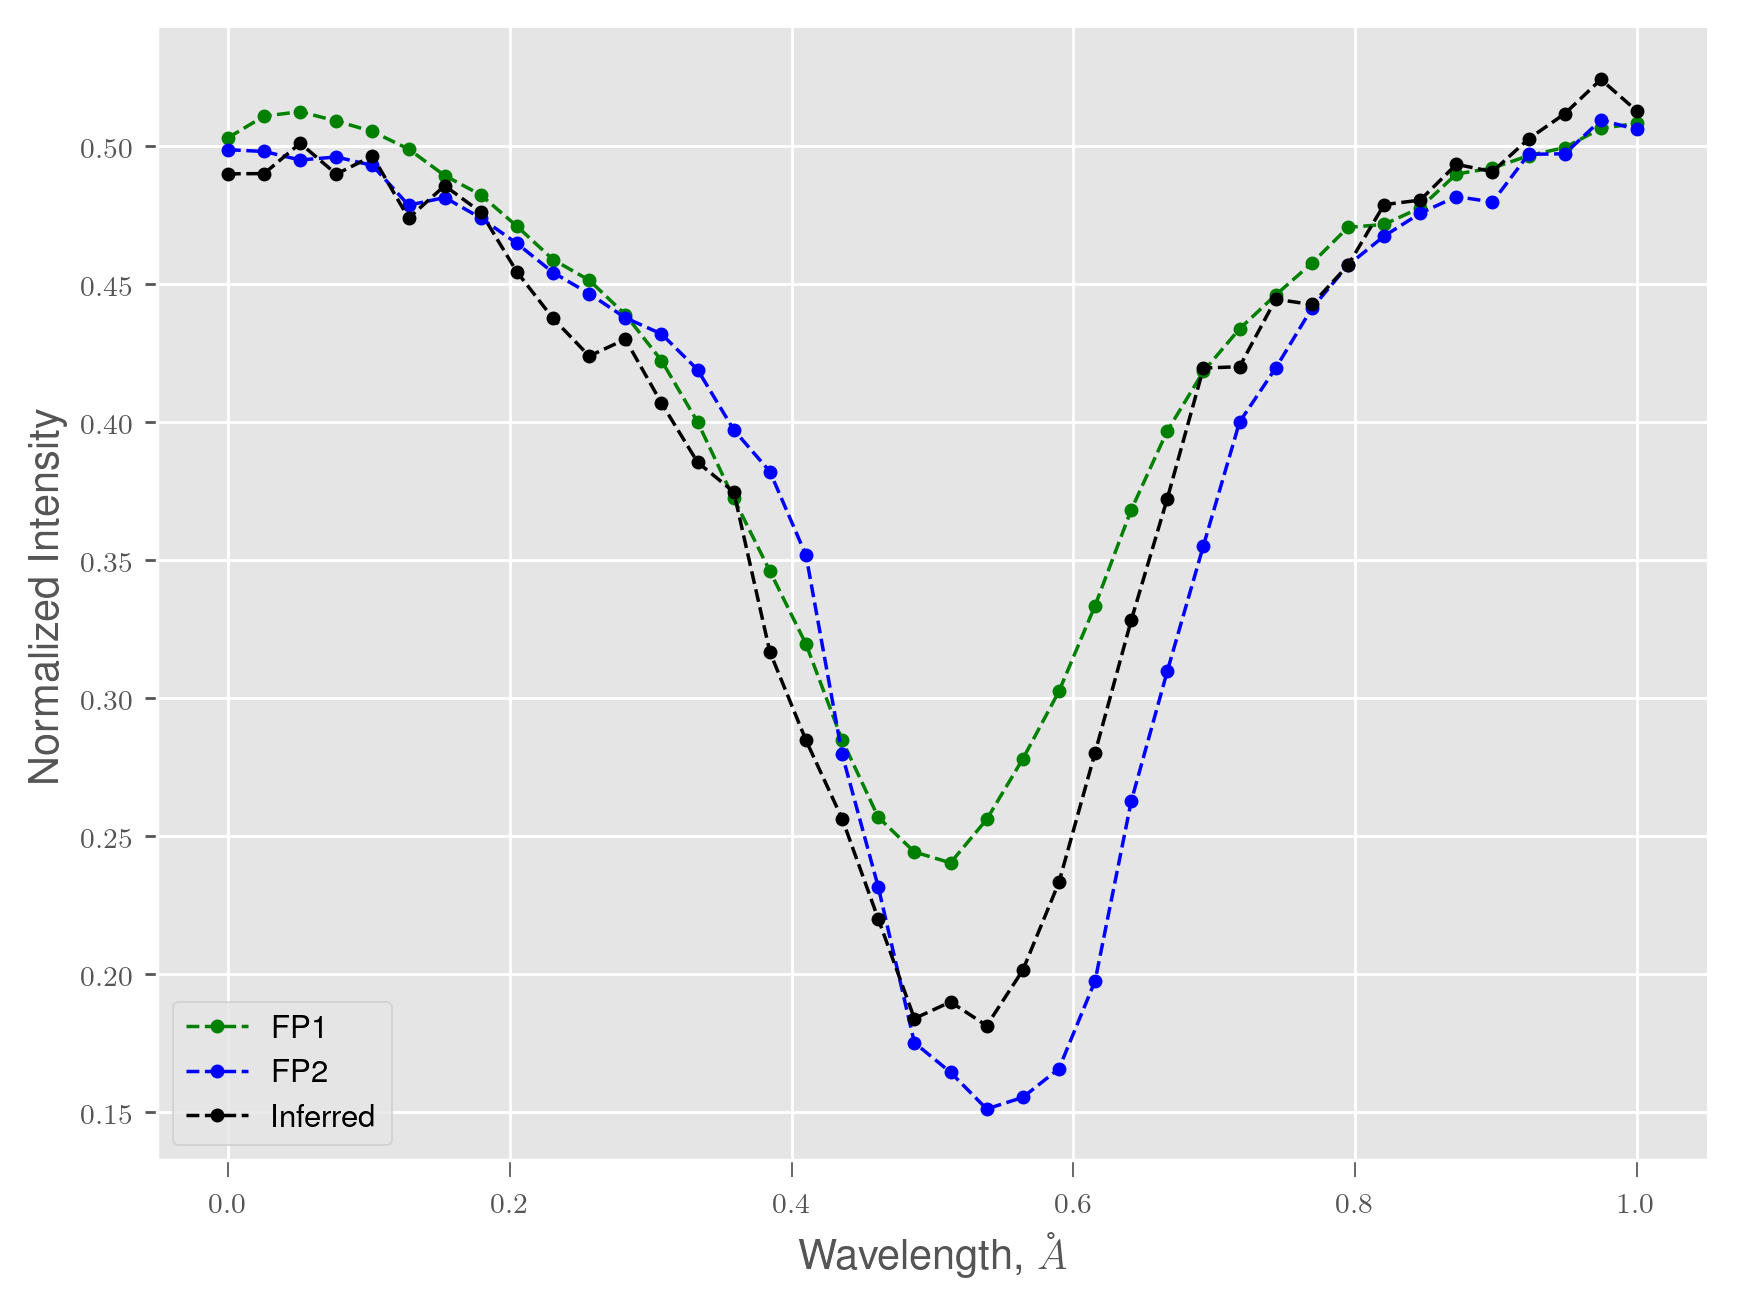

In [577]:
prevNum  = 90120
delta    = 1000


#im       = model.predict(train_set[:,:,:])
#plt.figure(dpi=200)
#plt.imshow(np.reshape(train_set[:,30,0],(968,968)))
#plt.show()
#plt.figure(dpi=200)
#plt.imshow(np.reshape(im[:,30],(968,968)))
#plt.show()
#plt.figure(dpi=200)
#plt.imshow(np.reshape(truth_set[:,30],(968,968)))
#plt.show()

res = model.predict(train_set[prevNum:prevNum+delta,:,:])

wavescale = np.linspace(0,1,num=waveNumd-1)
plot_spec_profile_comparison(wavescale,train_set[prevNum,:-1,0],truth_set[prevNum,:],res[0,:])

In [ ]:
train_set[:,0,50]   = indices
truth_set        = truth_set1

train_set = (np.swapaxes(train_set,1,2))
print(train_set.shape)
#truth_set = (np.swapaxes(truth_set,1,2))
print(truth_set.shape)

In [ ]:
im1 = np.reshape(train_set[:,0,0],(968,968))
im = plt.imshow(im1)
plt.colorbar(im)
plt.show()

The elapsed time for 1M Pixel inversion is:  84.94 seconds


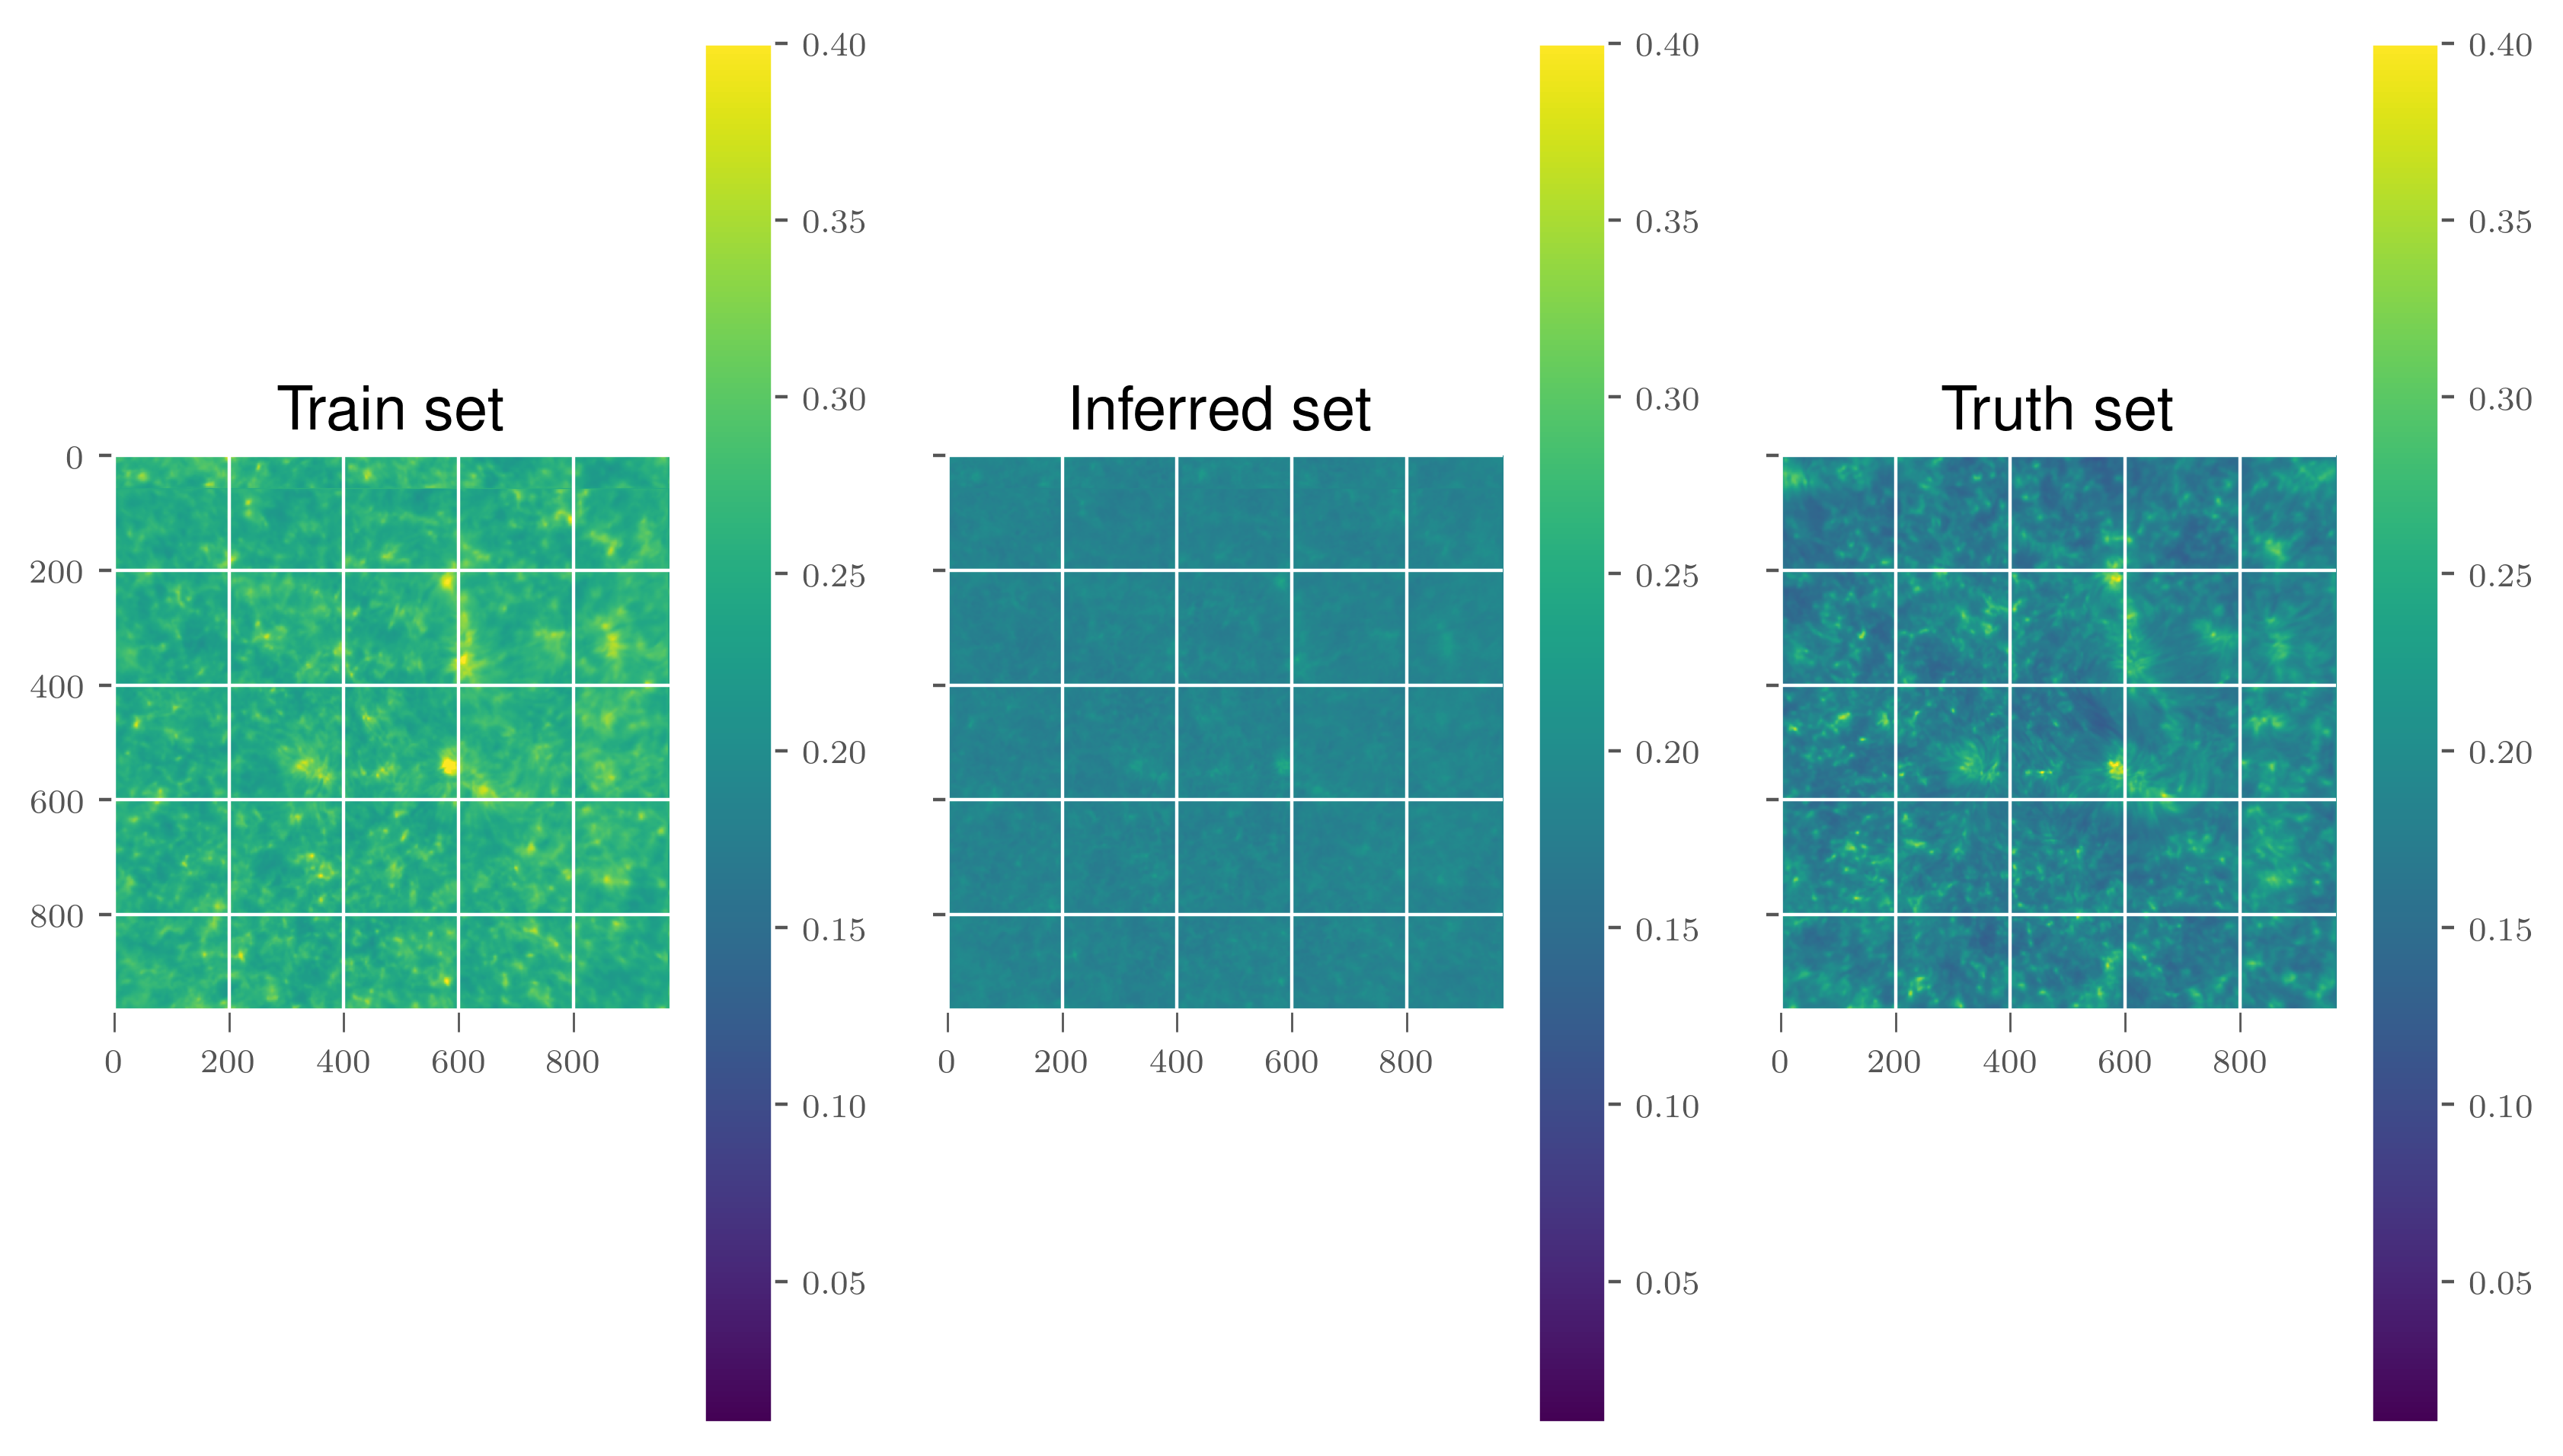

In [546]:
start = time.process_time()
im = model.predict(train_set[:,:,:])
print("The elapsed time for 1M Pixel inversion is: %6.2f seconds"%(time.process_time() - start))

dim1 = 18
dim2 = 22

vmin_a = 0.01
vmax_a = 0.4


figure, ax = plt.subplots(1,3,sharey=True)
figure.set_dpi(400)
figure.set_size_inches(10,6)
ax[0].set_title('Train set')
im0 = ax[0].imshow(np.reshape(np.mean(train_set[:,dim1:dim2,0],axis=1),(sizeX,sizeY)),vmin=vmin_a,vmax=vmax_a)
figure.colorbar(im0, ax=ax[0])
                   
ax[1].set_title('Inferred set')
im1 = ax[1].imshow(np.reshape((np.mean(im[:,dim1:dim2],axis=1)),(sizeX,sizeY)),vmin=vmin_a,vmax=vmax_a)
figure.colorbar(im1, ax=ax[1])

ax[2].set_title('Truth set')
im2 = ax[2].imshow(np.reshape(np.mean(truth_set[:,dim1:dim2],axis=1),(sizeX,sizeY)),vmin=vmin_a,vmax=vmax_a)
figure.colorbar(im2, ax=ax[2])
plt.show() 

[[0.4956342  0.49336687 0.47882366 ... 0.4713328  0.48077312 0.4460895 ]
 [0.5006832  0.49967685 0.48078588 ... 0.47261503 0.48478085 0.44574845]
 [0.502869   0.5047573  0.4815503  ... 0.4728442  0.48908195 0.44616032]
 ...
 [0.4463486  0.45089966 0.4436734  ... 0.47421014 0.4588608  0.47714078]
 [0.48486608 0.48140162 0.46955752 ... 0.4745788  0.47478652 0.45731646]
 [0.49212712 0.48749688 0.47586665 ... 0.4721061  0.47618222 0.450889  ]]


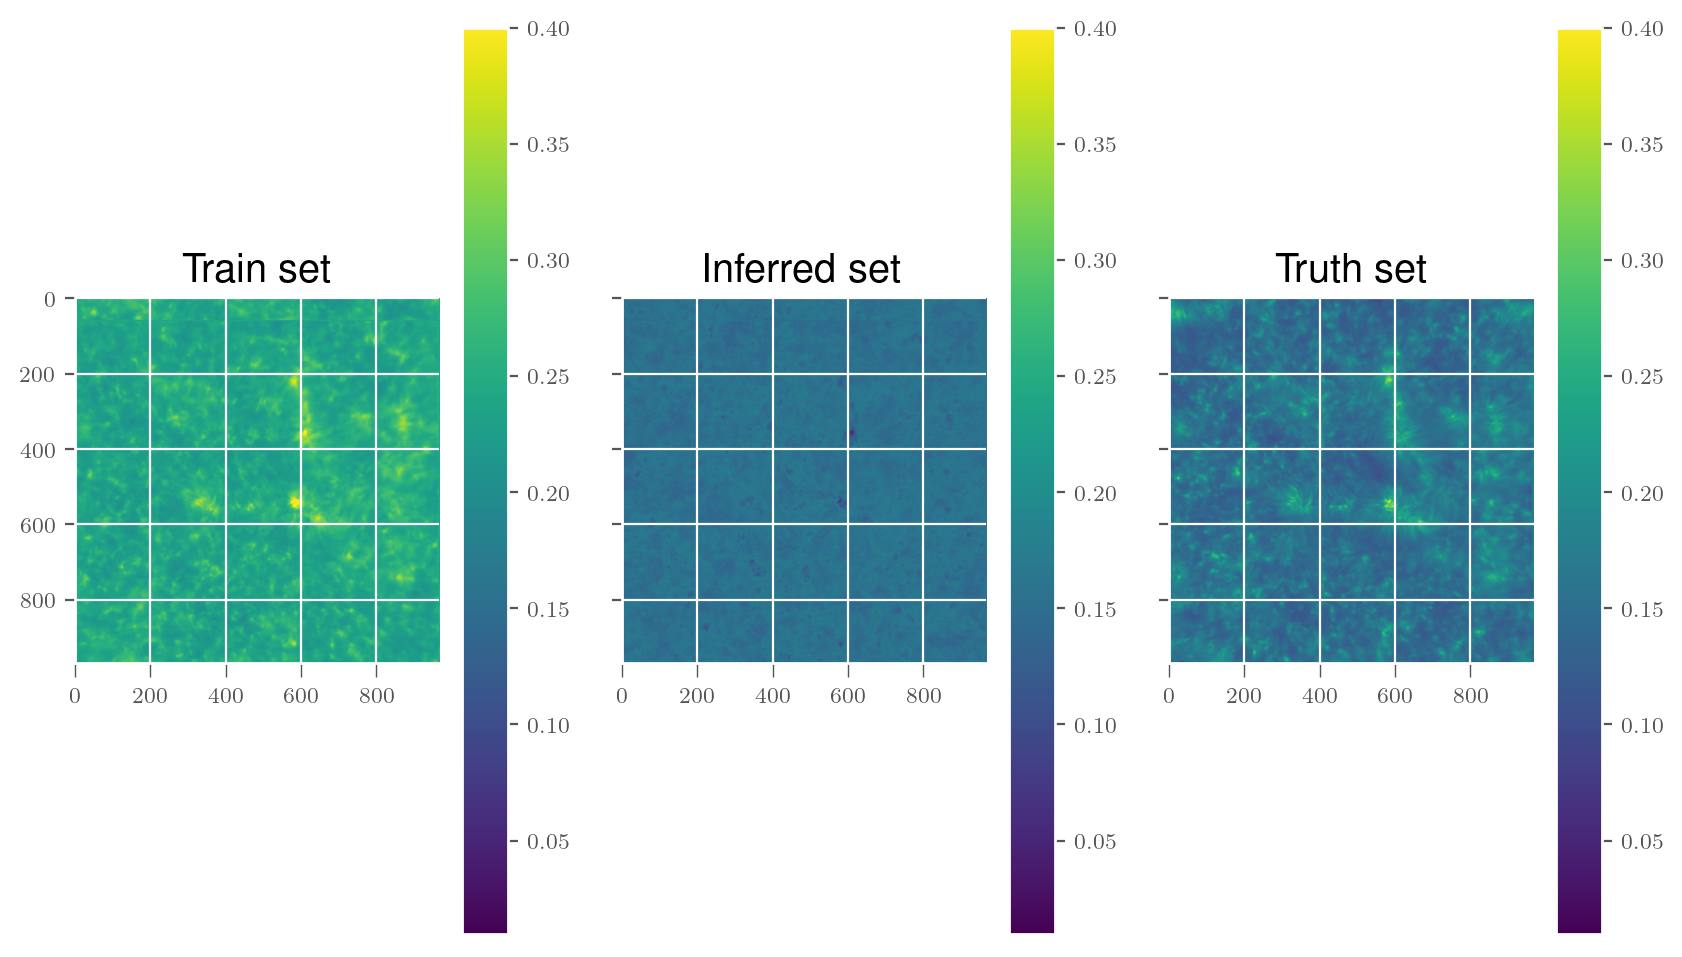

In [534]:
#im = model.predict(train_set[:,:,:])
print(im)

figure, ax = plt.subplots(1,3,sharey=True)
figure.set_dpi(200)
figure.set_size_inches(10,6)
ax[0].set_title('Train set')
im0 = ax[0].imshow(np.reshape(np.amin(train_set[:,5:-5,0],axis=1),(sizeX,sizeY)),vmin=vmin_a,vmax=vmax_a)
figure.colorbar(im0, ax=ax[0])
                   
ax[1].set_title('Inferred set')
im1 = ax[1].imshow(np.reshape((np.amin(im,axis=1)),(sizeX,sizeY)),vmin=vmin_a,vmax=vmax_a)
figure.colorbar(im1, ax=ax[1])

ax[2].set_title('Truth set')
im2 = ax[2].imshow(np.reshape(np.amin(truth_set,axis=1),(sizeX,sizeY)),vmin=vmin_a,vmax=vmax_a)
figure.colorbar(im2, ax=ax[2])
plt.show() 

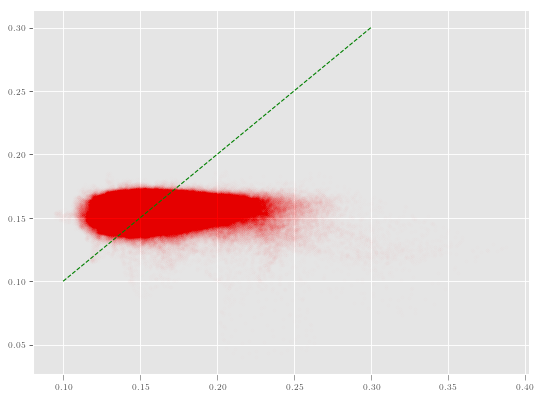

In [521]:
plt.plot(np.amin(truth_set,axis=1),(np.amin(im,axis=1)),'r.',alpha=0.0020)
x = np.linspace(0.1,.3)
plt.plot(x,x,'g--')
plt.show()